[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_D.ipynb)

# 量子化パラメータのモデル性能への影響

## Min-Maxスケーリングによる量子化

In [1]:
import torch

def quantize(tensor, bit_depth=8):
    # 最小値を0にする
    tensor_max = tensor.max()
    tensor_min = tensor.min()
    tensor = tensor - tensor_min

    # 0~(2^bit_depth - 1)の範囲にスケールする
    max_val = (2 ** bit_depth) - 1
    tensor = tensor * (max_val / (tensor_max - tensor_min))

    # clampで範囲外の値を制限
    tensor = torch.clamp(tensor, 0, max_val)

    # 整数化
    tensor = tensor.round().to(torch.int)

    return tensor, tensor_min, tensor_max

def dequantize(quantized_tensor, tensor_min, tensor_max, bit_depth=8):
    # 最大値と最小値を計算
    max_val = (2 ** bit_depth) - 1

    # 元のスケールに戻す
    tensor = quantized_tensor.float()

    # スケールの逆を適用
    tensor = tensor * ((tensor_max - tensor_min) / max_val) + tensor_min

    return tensor

def calculate_error(original_tensor, quantized_tensor, tensor_min, tensor_max, bit_depth=8):
    # dequantizeした値を得る
    dequantized_tensor = dequantize(quantized_tensor, tensor_min, tensor_max, bit_depth)

    # 誤差の計算 (MAE)
    error = (original_tensor - dequantized_tensor).abs().mean()  # 平均絶対誤差 (MAE)

    return error

# テスト
mean = 0.0
std_dev = 1.0
tensor_size = (3, 3)  # Size of the tensor
tensor = torch.normal(mean, std_dev, size=tensor_size)

quantized_tensor, tensor_min, tensor_max = quantize(tensor, bit_depth=8)
dequantized_tensor = dequantize(quantized_tensor, tensor_min, tensor_max, bit_depth=8)

# 誤差の計算
error = calculate_error(tensor, quantized_tensor, tensor_min, tensor_max, bit_depth=8)

print("Original Tensor:")
print(tensor)
print("Quantized Tensor:")
print(quantized_tensor)
print("Dequantized Tensor:")
print(dequantized_tensor)
print(f"Error (MAE): {error}")


Original Tensor:
tensor([[ 1.9991, -2.0932,  1.0059],
        [ 0.4970,  0.9956,  0.0238],
        [-0.0924, -0.0666,  0.1046]])
Quantized Tensor:
tensor([[255,   0, 193],
        [161, 192, 132],
        [125, 126, 137]], dtype=torch.int32)
Dequantized Tensor:
tensor([[ 1.9991, -2.0932,  1.0041],
        [ 0.4906,  0.9881,  0.0252],
        [-0.0872, -0.0711,  0.1054]])
Error (MAE): 0.00306390761397779


Epoch 1, Loss: 0.4406274417077682
Epoch 2, Loss: 0.17519650031834333
Epoch 3, Loss: 0.1278203807787092
Epoch 4, Loss: 0.10200545905348557
Epoch 5, Loss: 0.0853450886189326
Accuracy with 1-bit quantization: 9.76%
Accuracy with 2-bit quantization: 9.97%
Accuracy with 3-bit quantization: 56.40%
Accuracy with 4-bit quantization: 95.22%
Accuracy with 5-bit quantization: 96.80%
Accuracy with 6-bit quantization: 96.54%
Accuracy with 7-bit quantization: 96.66%
Accuracy with 8-bit quantization: 96.69%


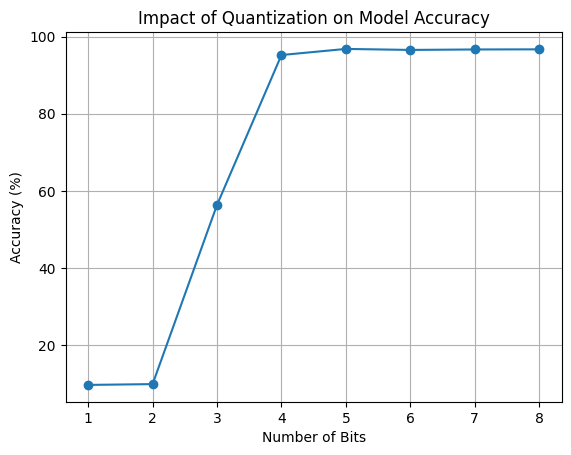

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
from torch.utils.data import DataLoader

# MNISTデータセットの前処理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# 簡単なニューラルネットワーク（MNIST用）
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 入力を1次元にフラット化
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# モデルの定義と学習
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.1)

# 学習
def train_model(model, trainloader, criterion, optimizer, epochs=2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

train_model(model, trainloader, criterion, optimizer, epochs=5)

# 推論関数
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# モデルの量子化関数
def quantize_model(model, n_bits):
    quantized_model = deepcopy(model)
    for param in quantized_model.parameters():
        quantized_tensor, min_value, max_value = quantize(param, n_bits)
        param.data = dequantize(quantized_tensor, min_value, max_value, n_bits)
    return quantized_model

# 1ビットから8ビットまでの精度変化を計算
def evaluate_quantization_impact(model, testloader, bit_range=range(1, 9)):
    results = {}
    for n_bits in bit_range:
        quantized_model = quantize_model(model, n_bits)
        accuracy = evaluate_model(quantized_model, testloader)
        results[n_bits] = accuracy
        print(f"Accuracy with {n_bits}-bit quantization: {accuracy:.2f}%")
    return results

# 量子化の影響を評価
results = evaluate_quantization_impact(model, testloader)

# 結果のプロット（オプション）
import matplotlib.pyplot as plt

bit_values = list(results.keys())
accuracies = list(results.values())

plt.plot(bit_values, accuracies, marker='o')
plt.xlabel('Number of Bits')
plt.ylabel('Accuracy (%)')
plt.title('Impact of Quantization on Model Accuracy')
plt.grid(True)
plt.show()


## 標準偏差に基づく量子化

tensor_minとtensor_maxの取り方によって量子化のモデルへの影響が変化します。

In [3]:
def quantize(tensor, bit_depth=8):
    # ガウス分布に基づいて範囲を決定する
    tensor_mean = tensor.mean()
    tensor_std = tensor.std()

    # より実用的な範囲: 平均 ± 3 * 標準偏差
    tensor_min = tensor_mean - 3 * tensor_std
    tensor_max = tensor_mean + 3 * tensor_std

    # 0~(2^bit_depth - 1)の範囲にスケールする
    max_val = (2 ** bit_depth) - 1
    tensor = tensor - tensor_min  # 最小値を0に

    # スケーリング
    tensor = tensor * (max_val / (tensor_max - tensor_min))

    # clampで範囲外の値を制限
    tensor = torch.clamp(tensor, 0, max_val)

    # 整数化
    tensor = tensor.round().to(torch.int)

    return tensor, tensor_min, tensor_max


Accuracy with 1-bit quantization: 24.85%
Accuracy with 2-bit quantization: 84.16%
Accuracy with 3-bit quantization: 95.05%
Accuracy with 4-bit quantization: 95.30%
Accuracy with 5-bit quantization: 95.56%
Accuracy with 6-bit quantization: 95.62%
Accuracy with 7-bit quantization: 95.51%
Accuracy with 8-bit quantization: 95.52%


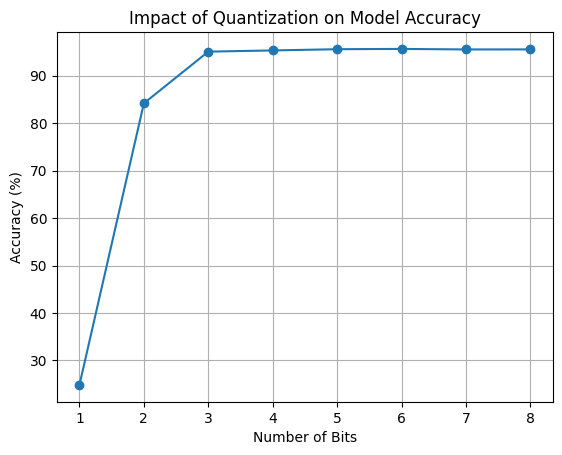

In [4]:
# モデルの量子化関数
def quantize_model(model, n_bits):
    quantized_model = deepcopy(model)
    for param in quantized_model.parameters():
        quantized_tensor, min_value, max_value = quantize(param, n_bits)
        param.data = dequantize(quantized_tensor, min_value, max_value, n_bits)
    return quantized_model

# 1ビットから8ビットまでの精度変化を計算
def evaluate_quantization_impact(model, testloader, bit_range=range(1, 9)):
    results = {}
    for n_bits in bit_range:
        quantized_model = quantize_model(model, n_bits)
        accuracy = evaluate_model(quantized_model, testloader)
        results[n_bits] = accuracy
        print(f"Accuracy with {n_bits}-bit quantization: {accuracy:.2f}%")
    return results

# 量子化の影響を評価
results = evaluate_quantization_impact(model, testloader)

# 結果のプロット（オプション）
import matplotlib.pyplot as plt

bit_values = list(results.keys())
accuracies = list(results.values())

plt.plot(bit_values, accuracies, marker='o')
plt.xlabel('Number of Bits')
plt.ylabel('Accuracy (%)')
plt.title('Impact of Quantization on Model Accuracy')
plt.grid(True)
plt.show()
